

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'fashion_mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': True,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.1, 'epochs':120}, 
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.3, 'epochs':120},
        'resnet':{'epochs':120}         
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

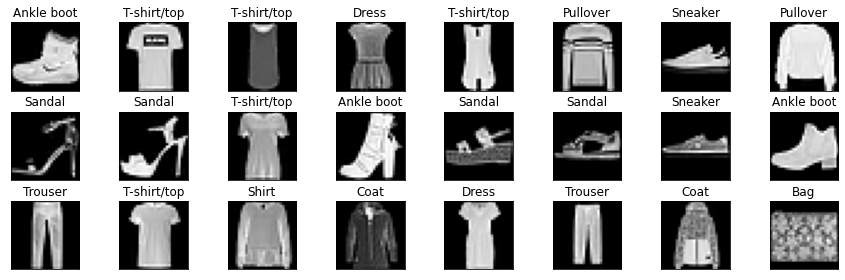

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

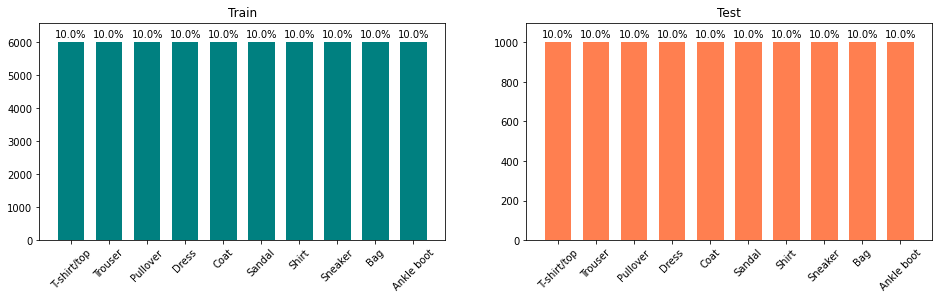

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

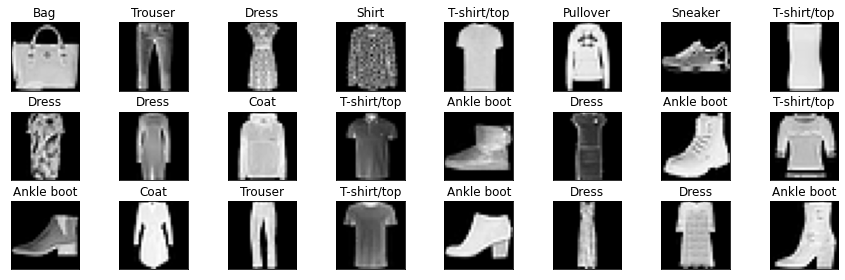

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

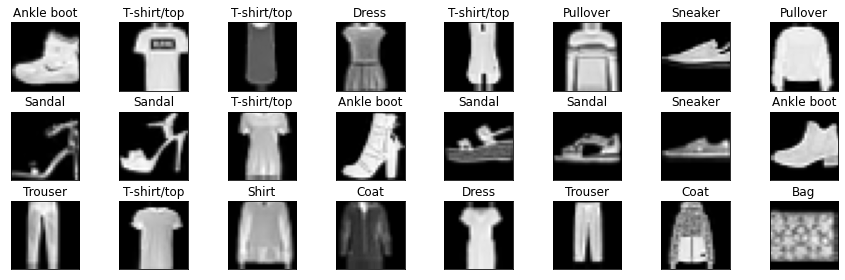

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

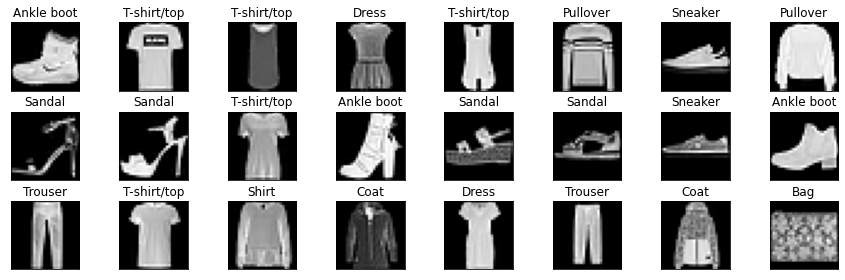

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = True


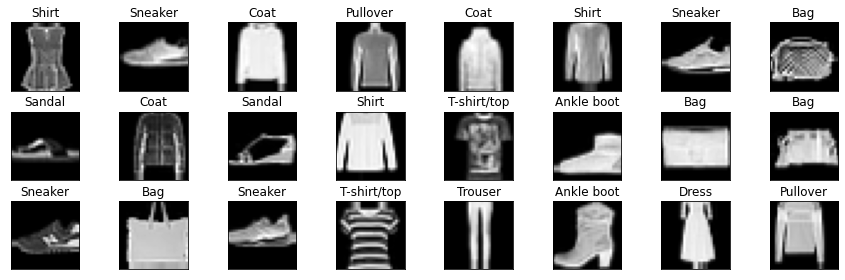

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 08:44:34,682: INFO: model_params.mlp1.dropout=0.1
2021-08-10 08:44:34,683: INFO: model_params.mlp1.layer_count=1
2021-08-10 08:44:34,683: INFO: model_params.mlp1.units=128
2021-08-10 08:44:34,740: INFO: learning_rate=0.001
2021-08-10 08:44:34,741: INFO: model_params.mlp1.clip_value=None
2021-08-10 08:44:34,760: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1
2021-08-10 08:44:34,762: INFO: model_params.mlp1.epochs=120
2021-08-10 08:44:34,763: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1, monitor=val_accuracy)
2021-08-10 08:44:34,763: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:44:34,764: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:44:34,765: INFO: use LearningRate

Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.7402 - accuracy: 0.7222 - val_loss: 0.565

2021-08-10 08:44:57,218: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 2/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5883 - accuracy: 0.7814 - val_loss: 0.5089 - val_accuracy: 0.8070
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:45:19,198: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 3/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.5426 - accuracy: 0.7993 - val_loss: 0.4803 - val_accuracy: 0.8224
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:45:41,659: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 4/120
1875/1875 [==============================] - 23s 12ms/step - loss: 0.5191 - accuracy: 0.8072 - val_loss: 0.4698 - val_accuracy: 0.8298
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:46:05,333: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 5/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4989 - accuracy: 0.8146 - val_loss: 0.4597 - val_accuracy: 0.8351
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:46:27,796: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 6/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4909 - accuracy: 0.8167 - val_loss: 0.4642 - val_accuracy: 0.8272
Epoch 7/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4761 - accuracy: 0.8240 - val_loss: 0.4183 - val_accuracy: 0.8453
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:47:11,624: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 8/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4717 - accuracy: 0.8247 - val_loss: 0.4276 - val_accuracy: 0.8447
Epoch 9/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4666 - accuracy: 0.8283 - val_loss: 0.4308 - val_accuracy: 0.8363
Epoch 10/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4591 - accuracy: 0.8291 - val_loss: 0.4358 - val_accuracy: 0.8283
Epoch 11/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4587 - accuracy: 0.8317 - val_loss: 0.4069 - val_accuracy: 0.8505
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:48:57,405: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 12/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4494 - accuracy: 0.8338 - val_loss: 0.4017 - val_accuracy: 0.8540
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:49:19,209: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 13/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4465 - accuracy: 0.8350 - val_loss: 0.4148 - val_accuracy: 0.8526
Epoch 14/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4487 - accuracy: 0.8339 - val_loss: 0.4082 - val_accuracy: 0.8494
Epoch 15/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4413 - accuracy: 0.8370 - val_loss: 0.4104 - val_accuracy: 0.8514
Epoch 16/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4401 - accuracy: 0.8359 - val_loss: 0.3937 - val_accuracy: 0.8594
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:50:45,323: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 17/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4341 - accuracy: 0.8389 - val_loss: 0.3908 - val_accuracy: 0.8593
Epoch 18/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4382 - accuracy: 0.8378 - val_loss: 0.4018 - val_accuracy: 0.8546
Epoch 19/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4319 - accuracy: 0.8399 - val_loss: 0.4044 - val_accuracy: 0.8521
Epoch 20/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4281 - accuracy: 0.8415 - val_loss: 0.3984 - val_accuracy: 0.8578
Epoch 21/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4274 - accuracy: 0.8427 - val_loss: 0.3964 - val_accuracy: 0.8587
Epoch 22/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4250 - accuracy: 0.8432 - val_loss: 0.3899 - val_accuracy: 0.8564
Epoch 23/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4252 - accuracy: 0.8431 - val_

2021-08-10 08:53:14,323: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 24/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4247 - accuracy: 0.8423 - val_loss: 0.3997 - val_accuracy: 0.8559
Epoch 25/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4200 - accuracy: 0.8457 - val_loss: 0.3860 - val_accuracy: 0.8601
Epoch 26/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4231 - accuracy: 0.8433 - val_loss: 0.4001 - val_accuracy: 0.8549
Epoch 27/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4185 - accuracy: 0.8465 - val_loss: 0.3948 - val_accuracy: 0.8563
Epoch 28/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4184 - accuracy: 0.8459 - val_loss: 0.3914 - val_accuracy: 0.8551
Epoch 29/120
1875/1875 [==============================] - 22s 11ms/step - loss: 0.4110 - accuracy: 0.8477 - val_loss: 0.3759 - val_accuracy: 0.8657
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 08:55:22,313: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 30/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4161 - accuracy: 0.8473 - val_loss: 0.3809 - val_accuracy: 0.8591
Epoch 31/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4140 - accuracy: 0.8471 - val_loss: 0.3857 - val_accuracy: 0.8564
Epoch 32/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4135 - accuracy: 0.8467 - val_loss: 0.3745 - val_accuracy: 0.8650
Epoch 33/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4132 - accuracy: 0.8483 - val_loss: 0.3975 - val_accuracy: 0.8547
Epoch 34/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4141 - accuracy: 0.8481 - val_loss: 0.3913 - val_accuracy: 0.8576
Epoch 35/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4129 - accuracy: 0.8468 - val_loss: 0.3704 - val_accuracy: 0.8653
Epoch 36/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4121 - accuracy: 0.8485 - val_

2021-08-10 08:58:13,055: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 38/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4077 - accuracy: 0.8501 - val_loss: 0.3778 - val_accuracy: 0.8639
Epoch 39/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4093 - accuracy: 0.8489 - val_loss: 0.3643 - val_accuracy: 0.8688
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 08:58:55,791: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 40/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4058 - accuracy: 0.8498 - val_loss: 0.3717 - val_accuracy: 0.8669
Epoch 41/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4078 - accuracy: 0.8506 - val_loss: 0.3680 - val_accuracy: 0.8667
Epoch 42/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4054 - accuracy: 0.8515 - val_loss: 0.3810 - val_accuracy: 0.8628
Epoch 43/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4048 - accuracy: 0.8499 - val_loss: 0.3885 - val_accuracy: 0.8573
Epoch 44/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4053 - accuracy: 0.8506 - val_loss: 0.3820 - val_accuracy: 0.8622
Epoch 45/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4058 - accuracy: 0.8509 - val_loss: 0.3784 - val_accuracy: 0.8596
Epoch 46/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4006 - accuracy: 0.8506 - val_

2021-08-10 09:04:35,117: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 56/120
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3717 - accuracy: 0.8628 - val_loss: 0.3542 - val_accuracy: 0.8733
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 09:04:56,900: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 57/120
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3722 - accuracy: 0.8629 - val_loss: 0.3523 - val_accuracy: 0.8719
Epoch 58/120
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3734 - accuracy: 0.8616 - val_loss: 0.3528 - val_accuracy: 0.8715
Epoch 59/120
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3698 - accuracy: 0.8631 - val_loss: 0.3585 - val_accuracy: 0.8699
Epoch 60/120
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3698 - accuracy: 0.8630 - val_loss: 0.3519 - val_accuracy: 0.8733
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
1875/1875 [==============================] - 21s 11

2021-08-10 09:06:43,827: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 62/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3637 - accuracy: 0.8658 - val_loss: 0.3472 - val_accuracy: 0.8720
Epoch 63/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3584 - accuracy: 0.8678 - val_loss: 0.3473 - val_accuracy: 0.8734
Epoch 64/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3627 - accuracy: 0.8645 - val_loss: 0.3471 - val_accuracy: 0.8718
Epoch 65/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3590 - accuracy: 0.8674 - val_loss: 0.3464 - val_accuracy: 0.8742
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 09:08:09,009: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 66/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3583 - accuracy: 0.8684 - val_loss: 0.3469 - val_accuracy: 0.8747
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 09:08:30,977: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 67/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3582 - accuracy: 0.8695 - val_loss: 0.3450 - val_accuracy: 0.8764
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 09:08:52,750: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 68/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3610 - accuracy: 0.8667 - val_loss: 0.3459 - val_accuracy: 0.8764
Epoch 69/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3587 - accuracy: 0.8680 - val_loss: 0.3465 - val_accuracy: 0.8753
Epoch 70/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3619 - accuracy: 0.8671 - val_loss: 0.3468 - val_accuracy: 0.8756
Epoch 71/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3592 - accuracy: 0.8686 - val_loss: 0.3468 - val_accuracy: 0.8774
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 09:10:18,319: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 72/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3588 - accuracy: 0.8665 - val_loss: 0.3470 - val_accuracy: 0.8746
Epoch 73/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3602 - accuracy: 0.8668 - val_loss: 0.3481 - val_accuracy: 0.8750
Epoch 74/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3600 - accuracy: 0.8683 - val_loss: 0.3469 - val_accuracy: 0.8751
Epoch 75/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3568 - accuracy: 0.8690 - val_loss: 0.3476 - val_accuracy: 0.8755
Epoch 76/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3594 - accuracy: 0.8674 - val_loss: 0.3466 - val_accuracy: 0.8749
Epoch 77/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3585 - accuracy: 0.8681 - val_loss: 0.3439 - val_accuracy: 0.8743
Epoch 78/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3565 - accuracy: 0.8692 - val_

2021-08-10 09:24:26,039: INFO: finish training [elapsed time: 2391.27 seconds]


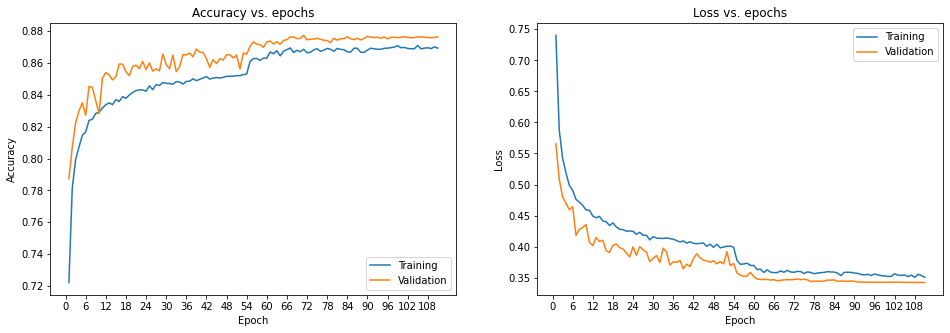

2021-08-10 09:24:26,665: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 09:24:37,608: INFO: test loss:0.3468
2021-08-10 09:24:37,609: INFO: test accuracy:0.8774
2021-08-10 09:24:37,610: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 09:24:37,612: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 09:24:37,613: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 09:24:37,614: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


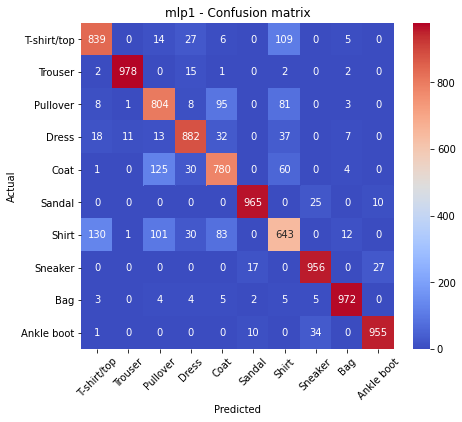

----------------------------------------sample analysis----------------------------------------


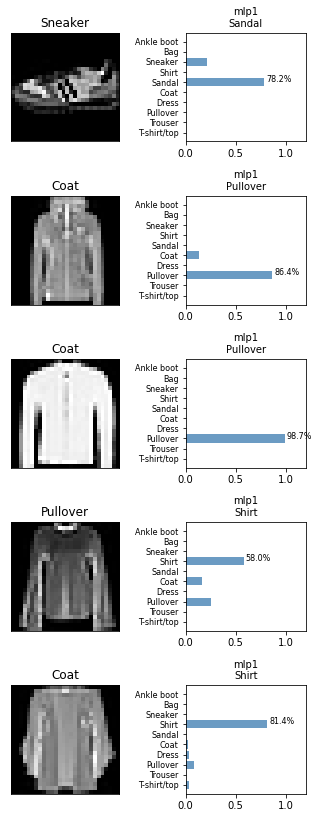

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,101770,2390.8,0.2987,0.3468,0.8896,0.8774,0.9914,0.989


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2021-08-10 09:24:40,948: INFO: model_params.lenet1.dropout=0.1
2021-08-10 09:24:41,051: INFO: learning_rate=0.001
2021-08-10 09:24:41,051: INFO: model_params.lenet1.clip_value=None
2021-08-10 09:24:41,058: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1
2021-08-10 09:24:41,067: INFO: model_params.lenet1.epochs=120
2021-08-10 09:24:41,068: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1, monitor=val_accuracy)
2021-08-10 09:24:41,068: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 09:24:41,069: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 09:24:41,070: INFO: use LearningRateScheduler()
2021-08-10 09:24:41,071: INFO: steps_per_epoch=1875


Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64   

2021-08-10 09:24:41,072: INFO: start training
2021-08-10 09:24:41,073: INFO: use_class_weight=False


Epoch 1/120
1875/1875 [==============================] - 24s 12ms/step - loss: 0.6636 - accuracy: 0.7480 - val_loss: 0.4480 - val_accuracy: 0.8337
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:25:06,822: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 2/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4922 - accuracy: 0.8146 - val_loss: 0.3862 - val_accuracy: 0.8550
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:25:30,932: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 3/120
1875/1875 [==============================] - 22s 11ms/step - loss: 0.4437 - accuracy: 0.8335 - val_loss: 0.3501 - val_accuracy: 0.8694
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:25:54,636: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 4/120
1875/1875 [==============================] - 22s 11ms/step - loss: 0.4194 - accuracy: 0.8423 - val_loss: 0.3365 - val_accuracy: 0.8726
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:26:18,580: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 5/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3995 - accuracy: 0.8505 - val_loss: 0.3222 - val_accuracy: 0.8798
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:26:41,938: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 6/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3872 - accuracy: 0.8534 - val_loss: 0.3148 - val_accuracy: 0.8840
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:27:05,609: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 7/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3768 - accuracy: 0.8583 - val_loss: 0.3067 - val_accuracy: 0.8877
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:27:29,390: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 8/120
1875/1875 [==============================] - 22s 11ms/step - loss: 0.3716 - accuracy: 0.8608 - val_loss: 0.3107 - val_accuracy: 0.8883
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:27:52,970: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 9/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3610 - accuracy: 0.8653 - val_loss: 0.3006 - val_accuracy: 0.8855
Epoch 10/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3575 - accuracy: 0.8660 - val_loss: 0.3034 - val_accuracy: 0.8866
Epoch 11/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3495 - accuracy: 0.8692 - val_loss: 0.3038 - val_accuracy: 0.8906
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:29:00,771: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 12/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3487 - accuracy: 0.8705 - val_loss: 0.3102 - val_accuracy: 0.8842
Epoch 13/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3427 - accuracy: 0.8712 - val_loss: 0.2816 - val_accuracy: 0.8966
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:29:46,657: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 14/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3411 - accuracy: 0.8727 - val_loss: 0.2777 - val_accuracy: 0.8983
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:30:11,080: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 15/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3331 - accuracy: 0.8754 - val_loss: 0.3176 - val_accuracy: 0.8817
Epoch 16/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3297 - accuracy: 0.8767 - val_loss: 0.2999 - val_accuracy: 0.8899
Epoch 17/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3266 - accuracy: 0.8776 - val_loss: 0.2776 - val_accuracy: 0.8965
Epoch 18/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3253 - accuracy: 0.8787 - val_loss: 0.2655 - val_accuracy: 0.8999
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 09:31:40,925: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 19/120
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3245 - accuracy: 0.8771 - val_loss: 0.2759 - val_accuracy: 0.8998
Epoch 20/120
1041/1875 [===============>..............] - ETA: 9s - loss: 0.3198 - accuracy: 0.8800

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [ ]:
type(helper.datasets.train_dataset)